# ASTR 502 Final Project: Predicting The Performance of Kinematic Lensing on WFIRST

Jiachuan Xu

Weak lensing (WL) is one of the methods directly probing the distribution of dark matter, and is one of the most important cosmological probes to provide stringent constraints on our cosmological model, or test general relativity theory. The non-uniform distribution of matter would distort the image of a distant galaxy. Traditional weak lensing method measure the shape correlation of galaxies separating at specific distance, and need a large sample to detect the signal out of galaxy's random alignment. This would introduce lots of systematics into the experiment:

- The random intrinsic alignment of galaxies behaves like shape noise, which is on average $\sim 10^3$ times the signal.
- As a result, we have to include more fainter galaxies into our sample to suppress the shape noise. As the galaxies go faint, the shape measurement is more uncertain.
- Get accurate redshift of galaxies when the sample is huge is expensive, so we use photometric redshift, which is another source of uncertainty.
- Since (some) source galaxies live in the same environment, their shape are correlated before their photons being perturbed by foreground shear field during its journey to the telescope. We can not distinguish the correlation in the shape is caused by foreground shear field or the local large scale structure.

Kinematic lensing (KL, [Huff et.al. 2013](https://ui.adsabs.harvard.edu/abs/2013arXiv1311.1489H/abstract)) is a new method to probe the cosmic shear field. Which utilize the spectral information in a novel way. It assumes a Tully-Fisher relation for the source galaxy, then with both photometric and spectral information, we can pin down the inclination of source galaxy and hence suppress the systematics.

In this report I will breifly summarize:
- How KL works (briefly)
- How to use MCMC to predict it's performance
- How to use PCA to help us determing the observation strategy


## Kinematic Lensing

Here is an illustration of shear field.
![shear illustration](JXu_data/shear_illus.pdf)
As you can see from the figure above, the background arrows array shows how the stuff on the source plane is being distorted by the shear field, and the blue ellipse is the shape of source galaxy projected along our line-of-sight. The red ellipse is the observed galaxy, being distorted along the principle axis of shear field (which is the black arrow in the figure).

![shear illustration](JXu_data/vmap_illus.pdf)

When spectral information is added, thing is different. As you can see, the black ellipse is the shape of observed galaxy, and the color map is the rotation velocity distribution. The red dash-dotted line shows maximum redshift direction, and the blue dash-dotted line shows the maximally blueshift direction. The grey dash-dotted line shows the zero line-of-sight velocity direction. **The direction of major/minor axis of galaxy image is different from the directin of maximally redshift/blueshift and 0 line-of-sight velocity**. The information of galaxy inclination is encoded in this offset: by taking spectrum along major and minor axes of the galaxy image, we can infer the inclination angle of the galaxy, and hence know how much ellipticity is caused by shear field.

## Predicting KL Performance on WFIRST

WFIRST is equipped with an array of 18 NIR detectors and also a high resolution grism (R$\sim 461(\lambda/1\mu m)$), which makes it possible to conduct self-containing kinematic lensing survey. To get information of the cosmological parameters, we have to measure the angular shear-shear power spectrum $C_{i,j}^{\kappa\kappa}(\ell)$, where $i$, $j$ are two tomographic bins.

In the framework of Baysian Inference, the "model" $M$ is our cosmological model, the "data" $D$ is our observable, angular shear-shear power spectra $C_{i,j}^{\kappa\kappa}(\ell)$. The model parameter $\mathbf{\theta}$ is our cosmological parameters $(\Omega_m, \sigma_8, n_s,w_0,w_a,\Omega_b,h_0)$. We assume the $\chi^2$ surface could be approximated by a multivariate Gaussian pretty well, so the posterior is modeled as 
$$
p(p_{co},p_{nu}|D,M) = exp(-\frac{1}{2}\chi^2)p(p_{co},p_{nu}|I)
$$

$$
\chi^2 = (D-M)^TC^{-1}(D-M)
$$

So we need
- fiducial data vector $M$, which is $C_{ij}^{\kappa\kappa}(\ell)$ calculated under fiducial cosmological parameter $p_{co}$ and nuisance parameter $p_{nu}$
- data vector $D$, which is $C_{ij}^{\kappa\kappa}(\ell)$ calculated somewhere in parameter space
- covariance metrix $C$, which is the covariance among observables $< C_{ij}^{\kappa}(\ell_1) C_{kl}^{\kappa}(\ell_2)>$

We use CosmoLike ([Krause & Eifler 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.470.2100K/abstract)) package to calculate the covariance matrix and data vector analytically. Although KL is a novel cosmic probe and is very different from traditional WL, so far we fit it into a "special weak lensing" regime, which means once we get reduced $C_{ij}^{\kappa\kappa}(\ell)$, we treat is as a weak lensing survey but:
- KL has significantly lower shape noise $\sigma_\epsilon(\approx 0.05)$ than WL ($\sim 0.3$)
- KL has lower source density, but has pretty accurate redshift measurement
- The source galaxies of KL following different redshift distribution than those of WL.


We are using emcee ([Foreman-Mackey et.al. 2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125..306F/abstract)) to run the chain. Since we have 28 parameters (7 cosmological parameters + 21 nuisance parameters) to be sampled, we have to set up MCMC sampler with 560 walkers, and for each walker we run 5000 steps, so in total we have a chain of length $560\times 5000 = 2,800,000$. (We doesn't push the chains in JXu_data due to it's large size. However we put a snippet of the chain to illustrate its fromat.)

### Convergence check

Here we are going to check whether the chain has been converged, and starting from where does the chain being stable. Since we only have one chain for each scenario, and we don't actually care the auto-correlation of our sample, we use the figure-of-merit (FoM) as an indicator of convergence of the chain.

In the example chain, we are sampling the 7 cosmological parameters. We are more interested about the posterior of the equation-of-state of the dark energy $(w_0,w_a)$. So we pick out those two dimensions, and calculate the covariance of those two parameters as the walkers moving.
>1. From MCMC chain, take a subchain, that is, slice the array by some index interval. This should be at the late stage (after burn-in phase).
>2. Calculate the covariance matrix of estimated parameters, i.e., $\Omega_m$, $w_0$, e.t.c., from the subchain.
$\hat{C}_{i,j}=\Sigma_{i=0}^n\frac{\theta_i \theta_j}{n}$
Where $\theta_i$ and $\theta_j$ are parameters to be estimated.
>3. Compute FoM = $\sqrt{det(C^{-1})}$
>4. Plot FoM as a function of index, see whether FoM converge as the chain goes on.

This quantity, qualitatively reflecting the "1/area" of the contour of $(w_0,w_a)$, can be viewed as the prediction power of the experiment w.r.t. some specific parameters.

In [36]:
import numpy as np
import os
from numpy.linalg import inv
from numpy.linalg import det
import matplotlib.pyplot as plt

### calculate FoM from chains
#.  fnames: 1-d array of string, containing the filenames of chain 
#.          files, including directory
#.  params: 1-d array of int, which params in the chain are you 
#.          interested to calculate FoM
#.  samp_size: int, how much points included in one FoM calculation
#.  start:  int, starting from where to calculate FoM
#
#   returns: N_files x N_bins array, and bins edge
def CalculateFoM(fnames, params, samp_size=200, start=0):

    N_files = len(fnames) # number of chains
    # read file
    datum = [np.genfromtxt(fname) for fname in fnames]
    # determining the number of bins needed
    datum_size = [len(d_) for d_ in datum]
    N_bins = int(np.max(datum_size)/samp_size)
    FOMDE = np.zeros([N_files, N_bins]) # dim: N_files x N_bins
    bin_edge = np.linspace(start,np.max(datum_size),N_bins+1)
    for j in range(N_files):
        for i in range(N_bins):
            l, r = start+i*samp_size, start+(i+1)*samp_size
            if l>= datum_size[j]:
                break
            cov = np.cov(datum[j][l:r],rowvar=False)
            cov_aim = cov[np.ix_(params,params)]
            FOMDE[j,i]=(np.power(det(inv(cov_aim)),1./len(params)))
    return FOMDE,bin_edge

/Users/jiachuanxu/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2445: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


[32.35102883 11.92388775]


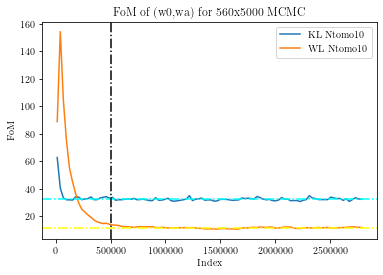

In [37]:
### Calculate FoM for two example chains
filedir = "JXu_data/"
fnames=[filedir+"like_WFIRST_KL_SN10_opti_shear_shear_cos_sigmae0.05_5000",
        filedir+"like_WFIRST_WL_SN10_opti_shear_shear_sys_opti_5000"]

FoM,bin_edge = CalculateFoM(fnames, [3,4], samp_size=28000)
steps = (bin_edge[1:]+bin_edge[:-1])/2.

fig = plt.figure()
plt.title("FoM of (w0,wa) for 560x5000 MCMC")
plt.plot(steps,FoM[0,:], label="KL Ntomo10")
plt.plot(steps,FoM[1,:], label="WL Ntomo10")

FoM_DE_asymp = np.nanmedian(FoM[:,17:], axis=1)
print(FoM_DE_asymp)
plt.axhline(FoM_DE_asymp[0],c='cyan',ls='-.')
plt.axhline(FoM_DE_asymp[1],c='yellow',ls='-.')
plt.legend()
plt.xlabel("Index")
plt.ylabel("FoM")
plt.axvline(500000, ls='-.', c='black')
plt.show()

As we can see, the two chains reach stable after $\sim$500,000 steps. So we will cut at 500,000 and drop the first part. We can also read off the asymptotic value of FoM for the two scenarios are $FoM_{KL}=32.35$ and $FoM_{WL}=11.92$, the KL is more than two times better than the WL.

### Contour Plots

After dropping the burn-in phase, we can construct the posterior in the parameter space. For the sake of visualization, we will consider the 2-d projection of the high dimension posterior, viewing from different different aspect
$$
p(\theta_i,\theta_j)=\int p(p_{co},p_{nu}|D,I)d\theta_1 d\theta_2 ... d\theta_{i-1}d\theta_{i+1}...d\theta_{j-1}d\theta_{j+1}...d\theta_n
$$

(A caveat is that, the projected best-fit parameter coincides with the high dimensin best-fit parameter when the shape of posterior is well-behaved. But under some circumstances, the 2-d best-fit parameter deviates from the high dimension best-fit position by non-negligible distance. This happens when there's a plateau of semi-likely regions in high dimension posterior, and is projected to different locations in the 2-d distribution, thus the overall likelyhood would surpass the true submit. So when there's obvious inconsistency in our result, we should check whether it is purely due to the projection effect.)

In [34]:
import numpy as np
from chainconsumer import ChainConsumer
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

### Plot contour for ONE parameters pair
#.  filename: 1-d array of strings, containing the filenames of chain 
#.          files, including directory
#.  out: filename for the plot
#.  chainnames: list of strings, scenario names for the chains
#.  paranames: list of strings, axis label for the two parameters
#.  fid: float 2-tuple, fiducial values for the two parameters
#.  para_pair: int 2-tuple, index of which two parameters we are considering
#.  burnin: list of int, number of burnin phase sample size
#.  kde: list of int, size of kde
#.  shade: list of boolean, plot shade on 1-sigma contour region?
#.  shade_alpha: list of float, transparency of shade regions
#.  linestyles: ls for contours
#.  linewidths: lw for contours
def multichain_single_plot(filename, out, chainnames, paranames,fid, para_pair,burnin,
                          kde=2,shade=False,shade_alpha=0.2,linestyles="--",linewidths=0.5):
    c = ChainConsumer()
    N_files = len(filename)
    # fix para length
    if not isinstance(shade, list):
        shade = [shade for i in range(N_files)]
    if not isinstance(shade_alpha, list):
        shade_alpha = [shade_alpha for i in range(N_files)]
    if not isinstance(linestyles, list):
        linestyles = [linestyles for i in range(N_files)]
    if not isinstance(linewidths, list):
        linewidths = [linewidths for i in range(N_files)]
    if not isinstance(burnin, list):
        burnin = [burnin for i in range(N_files)]
    if not isinstance(kde, list):
        kde = [kde for i in range(N_files)]
    if len(fid)!=2 or len(paranames)!=2:
        print("Error: fid and paranames should contain 2 elements!")
    # add chains into ChainConsumer object
    for i,fname in enumerate(filename):
        d = np.genfromtxt(fname)
        c.add_chain(d[burnin[i]:,para_pair],parameters=paranames, name =chainnames[i])
    # configure the plot
    c.configure(kde=kde, shade=shade, shade_alpha=shade_alpha, linestyles=linestyles,
                linewidths=linewidths, bar_shade=True)
    fig = c.plotter.plot(truth=fid,figsize=2.0,filename=out, parameters=paranames)

### Plot contour for MULTIPLE parameters pair
#.  filename: 1-d array of strings, containing the filenames of chain 
#.          files, including directory
#.  out: filename for the plot
#.  chainnames: list of strings, scenario names for the chains
#.  paranames: list of strings, axis label for the two parameters
#.  fid: list of floats, fiducial values for the two parameters
#.  para_pair: list of int, index of which two parameters we are considering
#.  burnin: list of int, number of burnin phase sample size
#.  shade: list of boolean, plot shade on 1-sigma contour region?
#.  shade_alpha: list of float, transparency of shade regions
#.  linestyles: ls for contours
#.  linewidths: lw for contours
def multichain_multi_plot(filename, out, chainnames, paranames,fid, start, stop, burnin, 
                          shade=False,shade_alpha=0.2,linestyles="--",linewidths=0.5):
    c = ChainConsumer()
    N_files = len(filename)
    if not isinstance(shade, list):
        shade = [shade for i in range(N_files)]
    if not isinstance(shade_alpha, list):
        shade_alpha = [shade_alpha for i in range(N_files)]
    if not isinstance(linestyles, list):
        linestyles = [linestyles for i in range(N_files)]
    if not isinstance(linewidths, list):
        linewidths = [linewidths for i in range(N_files)]
    if not isinstance(burnin, list):
        burnin = [burnin for i in range(N_files)]
    for i,fname in enumerate(filename):
        d = np.genfromtxt(fname)
        c.add_chain(d[burnin[i]:,start:stop],parameters=paranames, name =chainnames[i])
    c.configure(shade=shade, shade_alpha=shade_alpha, linestyles=linestyles,
                linewidths=linewidths)
    fig = c.plotter.plot(truth=fid,figsize=2.0,filename=out, parameters=paranames)

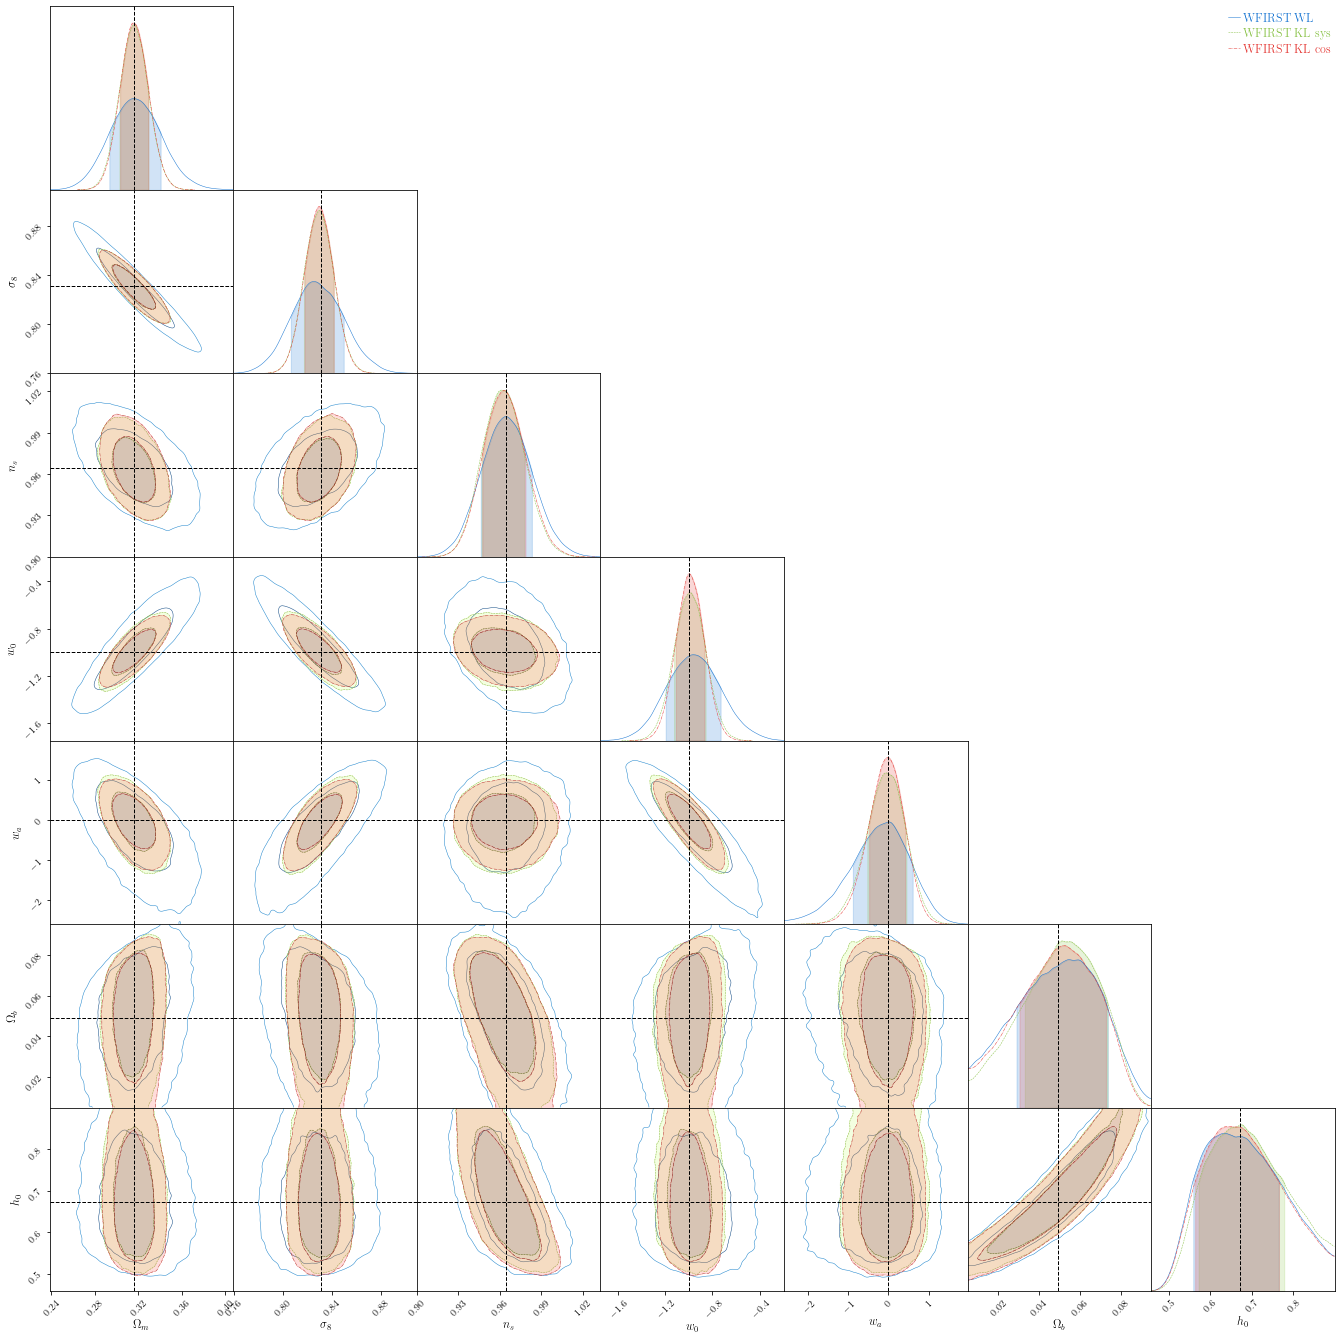

In [35]:
# full parameters pairwise contour
filename=["JXu_data/like_WFIRST_WL_SN10_opti_shear_shear_sys_opti_5000",# WL
          "JXu_data/like_WFIRST_KL_SN10_opti_shear_shear_sys_sigmae0.05_5000",# KL, sys
          "JXu_data/like_WFIRST_KL_SN10_opti_shear_shear_cos_sigmae0.05_5000"# KL, cos
          ]

chainnames=[
            r"WFIRST WL",
            r"WFIRST KL sys",
            r"WFIRST KL cos",
            ]
fid=[0.3156,0.831,0.9645,-1.,0.,0.0491685,0.6727] # fiducial cosmological parameters
paranames=[r"$\Omega_m$", r"$\sigma_8$",r"$n_s$", r"$w_0$", r"$w_a$",r"$\Omega_b$", r"$h_0$"]
multichain_multi_plot(filename, "JXu_data/WFIRST_WL_5000.jpg", chainnames, paranames, 
                      fid,0,7,burnin=500000, shade=[False,True,True],linestyles=['-','--','-.'])

Take-homes for the full parameters pairwise contour:
- There's hugh improvement in constraining power if we take kinematic information into account, especially for $\Omega_m-\sigma_8$ and $w_0-w_a$. The uncertainty decrease by half for those parameters.
- Marginalization over nuisance parameters doesn't degrade the result too much, which means the uncertainties are not dominant by (known) systematics.

### Finner tomography

One of the most expensive information in KL is the redshift. Since we pay a lot to get an accurate redshift, we want to know how could we utilize the redshift information to our best. One possible way is to devide the source galaxy samples into finer tomography bins. One may naively expect that if there's time evolution in the equation-of-state of DE, with more tomography bins people can catch the evolution better. To test that, we devide the sample into 30 tomography bins, and run the MCMC chains on three set of parameters
- set 1: $(w_0,w_a)=(-1,0)$
- set 2: $(w_0,w_a)=(-1.249,0.59)$
- set 3: $(w_0,w_a)=(-0.289,-2.21)$
In set 1, there's no time evolution in the EoS of DE. Set 2 and 3 corresponds to the boundary of $1\sigma$ confidence level from Planck + BAO/RSD measurements ([Planck collaboration 2018](https://ui.adsabs.harvard.edu/abs/2018arXiv180706209P/abstract)).

![Planck](JXu_data/Picture1.png)

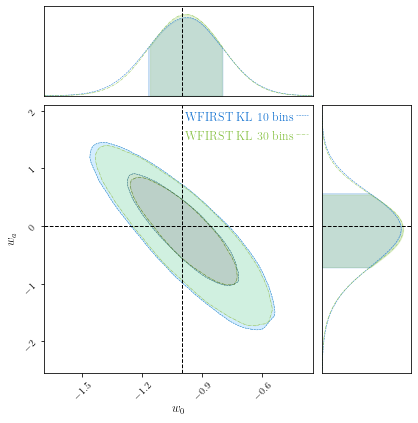

In [41]:
# zoom-in two parameters contour
# for comparison between 10/30 tomo bins
filename=["JXu_data/like_WFIRST_KL_shear_shear_cos_sigmae08_Ncl10_Ntomo10_5000",# 10 bins
          "JXu_data/like_WFIRST_KL_Ncl10_Ntomo30_shear_shear_cos_sigmae0.08_5000"]# 30 bins
chainnames = [r"WFIRST KL 10 bins", r"WFIRST KL 30 bins"]
fid=[0.3156,0.831,0.9645,-1.,0.,0.0491685,0.6727] # fiducial cosmological parameters
paranames=[r"$\Omega_m$", r"$\sigma_8$",r"$n_s$", r"$w_0$", r"$w_a$",r"$\Omega_b$", r"$h_0$"]
para_DE = [r"$w_0$", r"$w_a$"]
fid_DE = [-1.,0.]
multichain_single_plot(filename, "JXu_data/WFIRST_WL_10-30_5000.jpg", chainnames,para_DE, 
                       fid_DE,(3,4),burnin=500000, shade=[True,True],linestyles=['--','-.'])

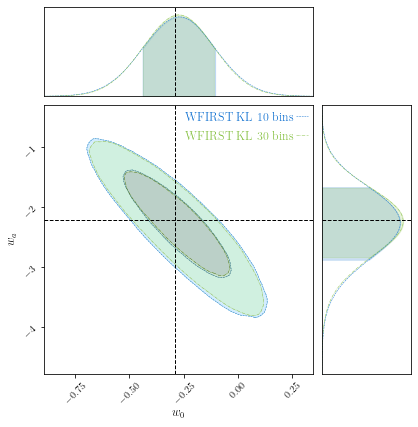

In [44]:
# zoom-in two parameters contour
# for comparison between 10/30 tomo bins
filename=["JXu_data/like_WFIRST_KL_shear_shear_cos_sigmae08_Ncl10_Ntomo10_DEl95CPL_5000",# 10 bins
          "JXu_data/like_WFIRST_KL_Ncl10_Ntomo10_DEl95CPL_shear_shear_cos_sigmae0.08_5000"]# 30 bins
chainnames = [r"WFIRST KL 10 bins", r"WFIRST KL 30 bins"]
fid=[0.3156,0.831,0.9645,-1.,0.,0.0491685,0.6727] # fiducial cosmological parameters
paranames=[r"$\Omega_m$", r"$\sigma_8$",r"$n_s$", r"$w_0$", r"$w_a$",r"$\Omega_b$", r"$h_0$"]
para_DE = [r"$w_0$", r"$w_a$"]
fid_DE = [-0.289,-2.21]
multichain_single_plot(filename, "JXu_data/WFIRST_WL_10-30_5000_u95.jpg", chainnames,para_DE, 
                       fid_DE,(3,4),burnin=500000, shade=[True,True],linestyles=['--','-.'])

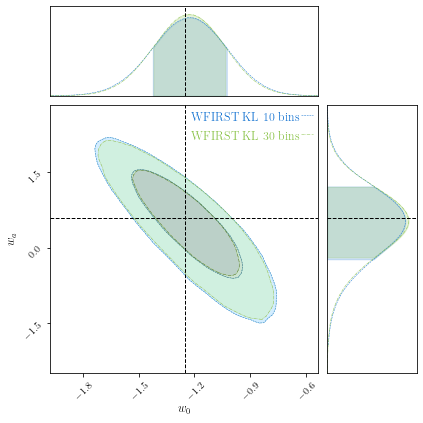

In [47]:
# zoom-in two parameters contour
# for comparison between 10/30 tomo bins
filename=["JXu_data/like_WFIRST_KL_shear_shear_cos_sigmae08_Ncl10_Ntomo10_DEu95CPL_5000",# 10 bins
          "JXu_data/like_WFIRST_KL_Ncl10_Ntomo30_DEu95CPL_shear_shear_cos_sigmae0.08_5000"]# 30 bins
chainnames = [r"WFIRST KL 10 bins", r"WFIRST KL 30 bins"]
fid=[0.3156,0.831,0.9645,-1.,0.,0.0491685,0.6727] # fiducial cosmological parameters
paranames=[r"$\Omega_m$", r"$\sigma_8$",r"$n_s$", r"$w_0$", r"$w_a$",r"$\Omega_b$", r"$h_0$"]
para_DE = [r"$w_0$", r"$w_a$"]
fid_DE = [-1.249,0.59]
multichain_single_plot(filename, "JXu_data/WFIRST_WL_10-30_5000_u95.jpg", chainnames,para_DE, 
                       fid_DE,(3,4),burnin=500000, shade=[True,True],linestyles=['--','-.'])

From the three figures above, we can see that we do not gain much more constraining power by deviding the sample into finer tomography bins. This is due to the smoothness of $C_{ij}^{\kappa\kappa}(\ell)$ as a function of redshift and $\ell$, even for $(w_0,w_a)$ deviated from $(-1,0)$. In that case 10 tomography bins contains almost the same information as the 30 tomography bins case. We have to figure out other schemes to utilize all the information as much as possible.

## Conclusion

- The kinematic lensing method could improve the constraining power of weak lensing by a factor of almost 2 in the sense of figure-of-merit when we only consider the angular shear-shear power spectra as observables.
- Marginalizing over the nuisance parameters doesn't degrade the result too much. The known systematics are not dominating the uncertainty
- By increasing the tomography bins, we can not get better constraints on the cosmological parameters.